In [4]:
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [9]:
f_plane = open('data/planesnet/planesnet.json')
print(f_plane)

<_io.TextIOWrapper name='data/planesnet/planesnet.json' mode='r' encoding='cp949'>


In [10]:
plane_dataset = json.load(f_plane)

In [12]:
f_plane.close()

In [13]:
plane_dataset.keys()

dict_keys(['data', 'labels', 'locations', 'scene_ids'])

In [114]:
# uint8은 0 ~ 255 까지 표현 가능
plane_x = np.array(plane_dataset['data']).astype('uint8')
plane_y = np.array(plane_dataset['labels']).astype('uint8')

In [115]:
print(plane_x.shape)
print(plane_y.shape)

plane_x = plane_x.reshape([-1,3,20,20]).transpose([0,2,3,1])
plane_x.shape

(32000, 1200)
(32000,)


(32000, 20, 20, 3)

In [116]:
# 데이터 섞기
shuffle_index = np.arange(32000)
np.random.shuffle(shuffle_index)

plane_x = plane_x[shuffle_index]
plane_y = plane_y[shuffle_index]

In [117]:
# 정규화
plane_x = plane_x / 255.

In [118]:
plane_classes = {0:'No Plane', 1:'Plane'}

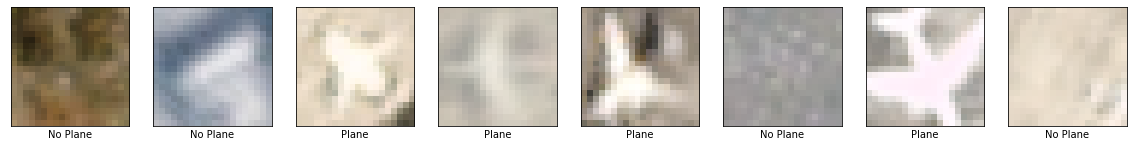

In [119]:
plt.figure(figsize=(20,10))
for i in range(8) :
    plt.subplot(1,8,i+1)
    # 축 설정
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(plane_x[i], cmap=plt.cm.binary)
    plt.xlabel(plane_classes[plane_y[i]])

In [251]:
# 데이터 나누기
plane_x_train, plane_x_test, plane_y_train, plane_y_test = train_test_split(plane_x, plane_y, test_size=0.2, random_state=777)

In [252]:
def cnn_model(inputshape) :
    model = tf.keras.Sequential([
        keras.layers.Conv2D(32, (5,5), activation='relu', padding='same', input_shape=inputshape),
        keras.layers.Conv2D(64, (5,5), activation='relu'),
        keras.layers.MaxPooling2D(2,2),
        keras.layers.Dropout(0.25),
        
        keras.layers.Conv2D(128, (5,5), activation='relu'),
        keras.layers.MaxPooling2D(2,2),
        keras.layers.Dropout(0.25),
        
        keras.layers.Flatten(),
        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.35),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.35),
        
        keras.layers.Dense(2, activation='softmax')
    ])
    model.summary()
    return model

In [253]:
training_plane = cnn_model((20,20,3))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 20, 20, 32)        2432      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 128)         204928    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 2, 2, 128)        

In [254]:
# callback 객체 생성
import os
checkpoint_path1 = 'cp.ckpt'
checkpoint_dir1 = os.path.dirname(checkpoint_path1)

cp_callback1 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path1, save_weights_only=True, verbose=1)

In [255]:
# 모델 설정
training_plane.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])

In [256]:
training_plane

In [257]:
import time

In [258]:
plane_x_train.shape
plane_y_train.shape

(25600,)

In [259]:
start_time_plane = time.time()
# validation_split -> train데이터에서 일부를 검증 데이터로 사용하겠다.
training_plane.fit(plane_x_train, plane_y_train, epochs=30, batch_size=256, validation_split=0.33, callbacks=[cp_callback1])

time_plane = start_time_plane - time.time()
time_plane

Train on 17152 samples, validate on 8448 samples
Epoch 1/30
16896/17152 [============================>.] - ETA: 0s - loss: 0.5751 - acc: 0.7485
Epoch 00001: saving model to cp.ckpt
17152/17152 [==============================] - 24s 1ms/sample - loss: 0.5746 - acc: 0.7481 - val_loss: 0.5194 - val_acc: 0.7493
Epoch 2/30
16896/17152 [============================>.] - ETA: 0s - loss: 0.3810 - acc: 0.8141
Epoch 00002: saving model to cp.ckpt
17152/17152 [==============================] - 23s 1ms/sample - loss: 0.3801 - acc: 0.8141 - val_loss: 0.3184 - val_acc: 0.8433
Epoch 3/30
16896/17152 [============================>.] - ETA: 0s - loss: 0.2478 - acc: 0.8945
Epoch 00003: saving model to cp.ckpt
17152/17152 [==============================] - 23s 1ms/sample - loss: 0.2458 - acc: 0.8954 - val_loss: 0.2194 - val_acc: 0.9147
Epoch 4/30
16896/17152 [============================>.] - ETA: 0s - loss: 0.1923 - acc: 0.9232
Epoch 00004: saving model to cp.ckpt
17152/17152 [==========================

-700.6115152835846

In [261]:
training_plane.evaluate(plane_x_test, plane_y_test)

6400/6400 [==============================] - 2s 383us/sample - loss: 0.0552 - acc: 0.9802


[0.055151176340732494, 0.98015624]

Text(0.5, 0, 'epoch')

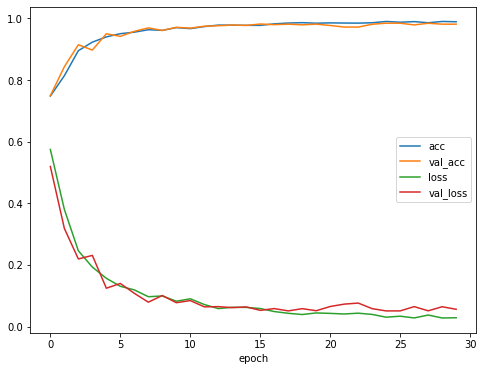

In [268]:
accuracy = training_plane.history.history['acc']
val_accuracy = training_plane.history.history['val_acc']

loss = training_plane.history.history['loss']
val_loss = training_plane.history.history['val_loss']

plt.figure(figsize=(8,6))
plt.plot(accuracy, label='acc')
plt.plot(val_accuracy, label='val_acc')
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()

plt.xlabel('epoch')

In [ ]:
# 연습문제

In [441]:
df = pd.read_csv('data/sonar.csv', header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,...,0.0116,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157,M
204,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,...,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067,M
205,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,...,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031,M
206,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,...,0.0086,0.0046,0.0126,0.0036,0.0035,0.0034,0.0079,0.0036,0.0048,M


In [442]:
x = df.iloc[:,:60]

# 정답데이터 라벨링
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

y = encoder.fit_transform(df.iloc[:,-1])

In [415]:
# train, test 데이터셋 분리
from sklearn.model_selection import train_test_split

seed = 1004

xTrain, xTest, yTrain, yTest = train_test_split(x,y,test_size=0.2,random_state=seed)

In [416]:
xTrain.shape

(166, 60)

In [457]:
# 모델 골격을 만들어 저장

base_model = Sequential([
    Dense(128, activation='relu', input_shape=[60]),
    Dense(64, activation='relu'),
    Dropout(0.2),
    
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),    
    Dense(1, activation='sigmoid')
])

base_model.save('base_model.h5')

In [459]:
# keras 모델링
from keras.models import Sequential
from keras.layers import *
from keras.models import load_model

sonar_model = load_model('base_model.h5')

sonar_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [460]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(patience=20, monitor='val_loss')

mcp = ModelCheckpoint('sonar_model/sonar_model.h5',
               monitor='val_loss',
               verbose=1,
               save_best_only=True)

In [461]:
sonar_model.fit(xTrain, yTrain, epochs=200, batch_size=80, validation_split=0.3, callbacks=[es])

sonar_model.evaluate(xTest, yTest)

Train on 116 samples, validate on 50 samples
Epoch 1/200
116/116 [==============================] - 1s 12ms/step - loss: 0.2611 - accuracy: 0.4310 - val_loss: 0.2458 - val_accuracy: 0.6200
Epoch 2/200
116/116 [==============================] - 0s 155us/step - loss: 0.2479 - accuracy: 0.5431 - val_loss: 0.2484 - val_accuracy: 0.5000
Epoch 3/200
116/116 [==============================] - 0s 172us/step - loss: 0.2468 - accuracy: 0.4828 - val_loss: 0.2507 - val_accuracy: 0.4400
Epoch 4/200
116/116 [==============================] - 0s 155us/step - loss: 0.2400 - accuracy: 0.6379 - val_loss: 0.2516 - val_accuracy: 0.4400
Epoch 5/200
116/116 [==============================] - 0s 155us/step - loss: 0.2418 - accuracy: 0.5603 - val_loss: 0.2524 - val_accuracy: 0.4200
Epoch 6/200
116/116 [==============================] - 0s 163us/step - loss: 0.2392 - accuracy: 0.6034 - val_loss: 0.2518 - val_accuracy: 0.4400
Epoch 7/200
116/116 [==============================] - 0s 172us/step - loss: 0.2346 - 

Epoch 57/200
116/116 [==============================] - 0s 164us/step - loss: 0.0461 - accuracy: 0.9741 - val_loss: 0.1027 - val_accuracy: 0.8800
Epoch 58/200
116/116 [==============================] - 0s 164us/step - loss: 0.0445 - accuracy: 0.9483 - val_loss: 0.1011 - val_accuracy: 0.8600
Epoch 59/200
116/116 [==============================] - 0s 164us/step - loss: 0.0436 - accuracy: 0.9569 - val_loss: 0.1016 - val_accuracy: 0.8600
Epoch 60/200
116/116 [==============================] - 0s 164us/step - loss: 0.0389 - accuracy: 0.9655 - val_loss: 0.1159 - val_accuracy: 0.8600
Epoch 61/200
116/116 [==============================] - 0s 164us/step - loss: 0.0528 - accuracy: 0.9397 - val_loss: 0.1116 - val_accuracy: 0.8400
Epoch 62/200
116/116 [==============================] - 0s 164us/step - loss: 0.0391 - accuracy: 0.9655 - val_loss: 0.1090 - val_accuracy: 0.8400
Epoch 63/200
116/116 [==============================] - 0s 155us/step - loss: 0.0424 - accuracy: 0.9483 - val_loss: 0.1071 -

[0.12599345544974008, 0.8333333134651184]

In [429]:
from sklearn.model_selection import StratifiedKFold

In [462]:
# k-fold 교차검증 (k=5)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed) 

score = []

for train, test in kfold.split(x,y) :
    
    sonar_model = load_model('sonar_model/sonar_model(0.88).h5')

    sonar_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    
    sonar_model.fit(x.iloc[train,:], y[train], epochs=200, batch_size=80,
                    validation_data=[x.iloc[test,:],y[test]], callbacks=[es])

    score.append(sonar_model.evaluate(x.iloc[test,:], y[test])[1])

print('교차검증 Acc : ',np.mean(score))

Train on 165 samples, validate on 43 samples
Epoch 1/200
165/165 [==============================] - 2s 9ms/step - loss: 0.0708 - accuracy: 0.9091 - val_loss: 0.0843 - val_accuracy: 0.8605
Epoch 2/200
165/165 [==============================] - 0s 139us/step - loss: 0.0707 - accuracy: 0.9030 - val_loss: 0.0569 - val_accuracy: 0.9302
Epoch 3/200
165/165 [==============================] - 0s 152us/step - loss: 0.0589 - accuracy: 0.9333 - val_loss: 0.0628 - val_accuracy: 0.9302
Epoch 4/200
165/165 [==============================] - 0s 145us/step - loss: 0.0497 - accuracy: 0.9455 - val_loss: 0.0663 - val_accuracy: 0.9070
Epoch 5/200
165/165 [==============================] - 0s 145us/step - loss: 0.0628 - accuracy: 0.9212 - val_loss: 0.0555 - val_accuracy: 0.9535
Epoch 6/200
165/165 [==============================] - 0s 139us/step - loss: 0.0579 - accuracy: 0.9394 - val_loss: 0.0529 - val_accuracy: 0.9302
Epoch 7/200
165/165 [==============================] - 0s 139us/step - loss: 0.0618 - a

167/167 [==============================] - 0s 168us/step - loss: 0.0789 - accuracy: 0.9042 - val_loss: 0.0343 - val_accuracy: 0.9512
Epoch 9/200
167/167 [==============================] - 0s 138us/step - loss: 0.0797 - accuracy: 0.8862 - val_loss: 0.0301 - val_accuracy: 1.0000
Epoch 10/200
167/167 [==============================] - 0s 156us/step - loss: 0.0706 - accuracy: 0.9162 - val_loss: 0.0419 - val_accuracy: 0.9512
Epoch 11/200
167/167 [==============================] - 0s 138us/step - loss: 0.0641 - accuracy: 0.9102 - val_loss: 0.0306 - val_accuracy: 0.9756
Epoch 12/200
167/167 [==============================] - 0s 144us/step - loss: 0.0551 - accuracy: 0.9401 - val_loss: 0.0350 - val_accuracy: 0.9756
Epoch 13/200
167/167 [==============================] - 0s 138us/step - loss: 0.0460 - accuracy: 0.9461 - val_loss: 0.0319 - val_accuracy: 1.0000
Epoch 14/200
167/167 [==============================] - 0s 144us/step - loss: 0.0613 - accuracy: 0.9281 - val_loss: 0.0300 - val_accuracy:

Epoch 5/200
167/167 [==============================] - 0s 161us/step - loss: 0.0604 - accuracy: 0.9281 - val_loss: 0.0974 - val_accuracy: 0.8293
Epoch 6/200
167/167 [==============================] - 0s 156us/step - loss: 0.0604 - accuracy: 0.9281 - val_loss: 0.0970 - val_accuracy: 0.8293
Epoch 7/200
167/167 [==============================] - 0s 156us/step - loss: 0.0518 - accuracy: 0.9521 - val_loss: 0.0931 - val_accuracy: 0.8780
Epoch 8/200
167/167 [==============================] - 0s 150us/step - loss: 0.0487 - accuracy: 0.9461 - val_loss: 0.0893 - val_accuracy: 0.9024
Epoch 9/200
167/167 [==============================] - 0s 144us/step - loss: 0.0435 - accuracy: 0.9641 - val_loss: 0.0848 - val_accuracy: 0.8780
Epoch 10/200
167/167 [==============================] - 0s 156us/step - loss: 0.0442 - accuracy: 0.9461 - val_loss: 0.0855 - val_accuracy: 0.8780
Epoch 11/200
167/167 [==============================] - 0s 162us/step - loss: 0.0491 - accuracy: 0.9461 - val_loss: 0.0816 - val_